In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
import itertools
import random
import warnings
warnings.filterwarnings('ignore')

#### Import datasets

In [2]:
fluo00 = pd.read_csv('datasets/bulk-fluo-00.csv', index_col='time')
od00 = pd.read_csv('datasets/od-00.csv', index_col='time')
fluo01 = pd.read_csv('datasets/bulk-fluo-01.csv', index_col='time')
od01 = pd.read_csv('datasets/od-01.csv', index_col='time')
fluo10 = pd.read_csv('datasets/bulk-fluo-10.csv', index_col='time')
od10 = pd.read_csv('datasets/od-10.csv', index_col='time')
fluo11 = pd.read_csv('datasets/bulk-fluo-11.csv', index_col='time')
od11 = pd.read_csv('datasets/od-11.csv', index_col='time')
gates = fluo11.columns.tolist()

In [3]:
#od
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def od_wrapper(t, k1, k2, c0):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_rates = (k1, k2)
    od_sol = odeint(od_model, c0, t, od_rates)
    return od_sol[:,0]

def od_inference(od):
    od_bounds = [(0, 0, 0), (1, 2, 0.1)]
    od_params = []
    od_t = od.index
    for idx in range(od.shape[1]):
        od_data = od.iloc[:,idx]
        opt, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)
        od_params.append(opt)
    return od_params

#fluorescence
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper(t, b, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, ind1, ind2, n, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = b + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = b + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def fit_multiple(fluo, od_params):
    
    title = fluo.columns.tolist()[0]
    
    f_t_i = fluo.index
    f_t = np.append(f_t_i, f_t_i)
    f_t = np.append(f_t, f_t_i)
    f_t = np.append(f_t, f_t_i)
    
    f_data_00 = fluo.iloc[:,0]
    f_data_01 = fluo.iloc[:,1]
    f_data_10 = fluo.iloc[:,2]
    f_data_11 = fluo.iloc[:,3]
    f_data = np.append(f_data_00, f_data_01)
    f_data = np.append(f_data, f_data_10)
    f_data = np.append(f_data, f_data_11)
    
    alpha_00, beta_00, c0_00 = od_params[0]
    alpha_01, beta_01, c0_01 = od_params[1]
    alpha_10, beta_10, c0_10 = od_params[2]
    alpha_11, beta_11, c0_11 = od_params[3]
    
    y0_00 = np.array([0, 0, 0, 0, c0_00])
    y0_01 = np.array([0, 0, 0, 0, c0_01])
    y0_10 = np.array([0, 0, 0, 0, c0_10])
    y0_11 = np.array([0, 0, 0, 0, c0_11])
    y0 = np.append(y0_00, y0_01)
    y0 = np.append(y0, y0_10)
    y0 = np.append(y0, y0_11)
    extra_00 = (alpha_00, beta_00)
    extra_01 = (alpha_01, beta_01)
    extra_10 = (alpha_10, beta_10)
    extra_11 = (alpha_11, beta_11)
    
    parameters = ['b', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K']
    init_guess = [1e-1, 1, 1, 1e-6, 1e-3, 1e2, 1e-2, 1]
    gate_bounds_together = [np.array(init_guess)*0, np.array(init_guess)*100]
    
    def model_fit_00(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, 0, 0, 4, extra_00, y0_00)
        return fit[3]
    
    def model_fit_01(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, 0, 1, 4, extra_01, y0_01)
        return fit[3]
    
    def model_fit_10(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, 1, 0, 4, extra_10, y0_10)
        return fit[3]
    
    def model_fit_11(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, 1, 1, 4, extra_11, y0_11)
        return fit[3]
    
    def model_fit(t, a, b, c, d, e, f, g, h):
        result_00 = model_fit_00(f_t_i, a, b, c, d, e, f, g, h)
        result_01 = model_fit_01(f_t_i, a, b, c, d, e, f, g, h)
        result_10 = model_fit_10(f_t_i, a, b, c, d, e, f, g, h)
        result_11 = model_fit_11(f_t_i, a, b, c, d, e, f, g, h)
        
        result = np.append(result_00, result_01)
        result = np.append(result, result_10)
        result = np.append(result, result_11)
        
        return result
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_t, f_df, f_sim, f_data

In [4]:
gates = fluo11.columns.tolist()
f_t_res_all = []
f_df_res_all = []
f_sim_res_all = []
f_data_res_all = []

for gate in tqdm(gates):
    
    fluo_selected = pd.concat([fluo00[gate], fluo01[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo10[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo11[gate]], axis=1)
    od_selected = pd.concat([od00[gate], od01[gate]], axis=1)
    od_selected = pd.concat([od_selected, od10[gate]], axis=1)
    od_selected = pd.concat([od_selected, od11[gate]], axis=1)
    
    od_params_selected = od_inference(od_selected)
    
    f_t_res, f_df_res, f_sim_res, f_data_res = fit_multiple(fluo_selected, od_params_selected)
    f_t_res_all.append(f_t_res)
    f_df_res_all.append(f_df_res)
    f_sim_res_all.append(f_sim_res)
    f_data_res_all.append(f_data_res)

100%|██████████| 21/21 [02:49<00:00,  8.08s/it]


### Layering the Models

In [142]:
class Gate:
    def __init__(self, name, gate_params, od_params, fluo_data, od_data):
        
        #metadata
        self.name = name
        
        #parameters
        self.syn_ECFn = gate_params[0]
        self.syn_ECFc = gate_params[1]
        self.syn_ECF = gate_params[2]
        self.deg = gate_params[3]
        self.syn_GFP = gate_params[4]
        self.deg_GFP = gate_params[5]
        self.K = gate_params[6]
        self.n = gate_params[7]
        self.alpha = od_params[0]
        self.beta = od_params[1]
        self.gamma = 0
        
        #initial states
        self.ECFn = 0
        self.ECFc = 0
        self.ECF = 0
        self.GFP = 0
        self.OD = od_params[2]
        
        #derivative states
        self.dECFn = 0
        self.dECFc = 0
        self.dECF = 0
        self.dGFP = 0
        self.dOD = 0
        
        #connection
        self.connection = None
        
        #data
        self.fluo_data = fluo_data
        self.od_data = od_data
        
    def get_params(self):
        return [self.syn_ECFn, self.syn_ECFc, self.syn_ECF, self.deg, self.syn_GFP, self.deg_GFP, self.K, self.n, self.alpha, self.beta]
    
    def get_init_states(self):
        return [self.ECFn, self.ECFc, self.ECF, self.GFP, self.OD]
    
class Connection:
    def __init__(self, name, input1, input2, output, level, index, input1_idx, input2_idx, output_idx):
        self.name = name
        self.input1 = input1
        self.input2 = input2
        self.output = output
        self.level = level #0: input, 1: intermediate, 2:output
        self.index = index
        self.input1_idx = input1_idx
        self.input2_idx = input2_idx
        self.output_idx = output_idx
         
class Circuit:
    def __init__(self, fluo, od, gate_params, od_params, schema, arrangement):
        
        #inducers
        self.inducers = [1] * 8
        
        #gate
        self.gates = []
        for i in arrangement:
            self.gates.append(Gate('g' + str(i), gate_params[i], od_params[i], fluo.iloc[:,i], od.iloc[:,i]))
        
        self.connections = [
            Connection('c1', self.inducers[0], self.inducers[1], None, 0, 0, 0, 1, 4),
            Connection('c2', self.inducers[2], self.inducers[3], None, 0, 1, 2, 3, 4),
            Connection('c3', self.inducers[4], self.inducers[5], None, 0, 4, 0, 1, 6),
            Connection('c4', self.inducers[6], self.inducers[7], None, 0, 3, 6, 7, 5),
            Connection('c5', self.gates[0], self.gates[1], None, 1, 4, 0, 1, 6),
            Connection('c6', self.gates[2], self.gates[3], None, 1, 5, 2, 3, 6),
            Connection('c7', self.gates[4], self.gates[5], None, 2, 6, 4, 5, 6)
        ]
        
        for i, g in enumerate(self.gates):
            g.connection = self.connections[i]

    def get_all_params(self):
        params = []
        for g in self.gates:
            params.append(g.get_params())
        return np.array(params)
    
    def get_all_init_states(self):
        init_states = []
        for g in self.gates:
            init_states.append(g.get_init_states())
        return np.array(init_states)

In [143]:
def hill_equation2(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper2(t, circuit):
    
    y0 = np.array([g.get_init_states() for g in circuit.gates]).ravel()
    
    def gate_model2(y, t):
        
        yi = np.reshape(y, (-1, 5))
        yn = []
        
        for i, g in enumerate(circuit.gates):
            
            g.ECFn, g.ECFc, g.ECF, g.GFP, g.OD = yi[i]
        
            #growth
            g.gamma = growth_rate(t, g.OD, g.alpha, g.beta)
            g.dOD = g.gamma * g.OD
            
            #level 0 (input)
            if g.connection.level==0:
                
                g.dECFn = g.syn_ECFn * g.connection.input1 - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * g.connection.input2 - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                #g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
                
            #level 1 (middle)
            elif g.connection.level==1:

                input1 = g.connection.input1
                input2 = g.connection.input2
                g.dECFn = g.syn_ECFn * hill_equation(input1.ECF, input1.K, input1.n) - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * hill_equation(input2.ECF, input2.K, input2.n) - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                #g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
                
            #level 2 (output)
            elif g.connection.level==2:
                
                input1 = g.connection.input1
                input2 = g.connection.input2
                
                g.dECFn = g.syn_ECFn * hill_equation(input1.ECF, input1.K, input1.n) - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * hill_equation(input2.ECF, input2.K, input2.n) - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
        
        return np.array(yn).ravel()
    
    solution = odeint(gate_model2, y0, t)
    return solution.transpose()

### Exhaustive Search

In [144]:
gate_params_selected = [par['Value'] for par in f_df_deg]
all_arr = [list(a) for a in list(itertools.permutations(np.arange(len(gate_params_selected)), 7))]
len(all_arr)

KeyboardInterrupt: 

In [15]:
gate_params_selected = [par['Value'] for par in f_df_deg]
#arr = np.arange(len(gate_params_selected))
#np.random.shuffle(arr)
#print(arr)
f_t = fluo_selected.index

results = []
for i, arr in enumerate(tqdm(all_arr)):
    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, arr)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    dyn = gfp.max() - gfp.min()
    results.append((dyn, arr))

100%|██████████| 5040/5040 [03:19<00:00, 25.29it/s]


 20%|██        | 2/10 [00:00<00:00, 17.17it/s]

Best result 111984.93874136555


100%|██████████| 10/10 [00:00<00:00, 22.20it/s]


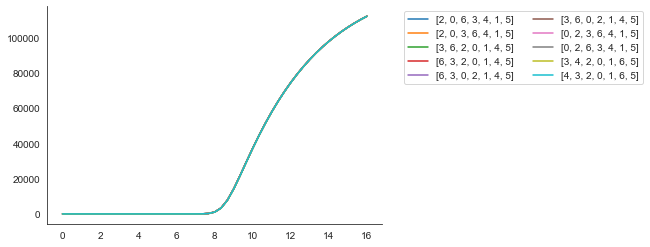

In [16]:
best_results = sorted(results, reverse=True)[:10]
print('Best result', best_results[0][0])
for i, res in enumerate(tqdm(best_results)):
    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, res[1])
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    plt.plot(gfp, label= res[1])
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

### Genetic Algorithm

In [145]:
len(selected)

13

In [146]:
def initialPopulation(pop_size, num_indiv, length):
    population = []
    arrangement = np.arange(num_indiv)
    for i in range(pop_size):
        new_arrangement = [i for i in arrangement]
        np.random.shuffle(new_arrangement)
        population.append(new_arrangement[:length])
    return np.array(population)

def calculateFitness(pop):
    
    f_t = fluo_selected.index
    fitness = []
    
    for i, p in enumerate(pop):
        circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, p)
        model = gate_wrapper2(f_t, circuit)
        gfp = pd.Series(model[33], index=f_t/60)
        fitness.append(gfp.max()-gfp.min())
    return np.array(fitness)

def rankIndiv(population):
    
    fitness = calculateFitness(population)
    fitnessResults = [(a, b) for a, b in zip(population, fitness)]
    return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))

def selection(popRanked, eliteSize):
    
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        selected = selectionResults[i]
        matingpool.append(selected)
    return matingpool

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    
    return child

def breedPopulation(matingpool, eliteSize, length):
    
    children = []
    nonElite = len(matingpool) - eliteSize
    pool = random.choices(matingpool, k=len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, nonElite):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child[:length])
    
    return np.array(children)

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return np.array(mutatedPop)

def nextGeneration(currentGen, eliteSize, mutationRate, length):
    
    popRanked = rankIndiv(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, length)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = initialPopulation(popSize, candidates, length)
    pop_copy = [i for i in pop]
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
    return pop_copy, rankIndiv(pop)

pop_copy, result = geneticAlgorithm(popSize=100, eliteSize=20, mutationRate=0.01, generations=50, candidates=len(selected), length=7)
#result

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


[6 4 9 7 2 1 0]
240227.33330534803


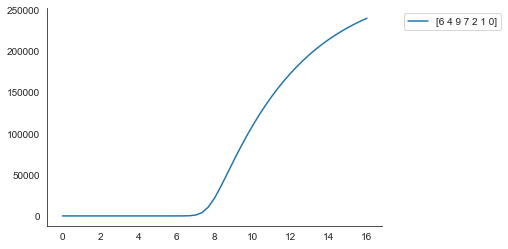

In [147]:
gate_params_selected = [par['Value'] for par in f_df_deg]
ga_arrangement = result[0][0]
print(ga_arrangement)

f_t = fluo_selected.index
for ar in pop_copy[:1]:

    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, ga_arrangement)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    print(gfp.max()-gfp.min())
    plt.plot(gfp, label=ga_arrangement)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

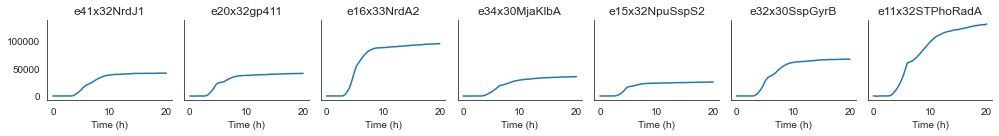

In [18]:
final_asg = fluo_selected[[fluo_selected.columns[j] for j in ga_arrangement]]
num_col = 7
num_row = 1
f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < num_traces:
        ax.plot(final_asg.index / 60, final_asg.iloc[:, i])
        ax.set_title(final_asg.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

100%|██████████| 20/20 [02:25<00:00,  7.28s/it]


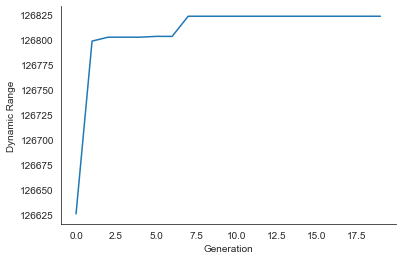

In [19]:
def geneticAlgorithmPlot(pop_copy, popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = [i for i in pop_copy]
    progress = []
    progress.append(rankIndiv(pop)[0][1])
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
        progress.append(rankIndiv(pop)[0][1])
    return progress
    
progress = geneticAlgorithmPlot(pop_copy, popSize=100, eliteSize=20, mutationRate=0.01, generations=20, candidates=len(selected), length=7)
plt.figure(figsize=[6, 4])
plt.plot(progress[:20])
plt.ylabel('Dynamic Range')
plt.xlabel('Generation')
sns.despine()
plt.show()